In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy

import statsmodels.api as sm
from scipy.stats import ttest_ind
from matplotlib import rcParams

In [3]:
#Read 5 year dataset into a dataframe
df_crime = pd.read_csv("incidents-5y.csv")


In [3]:
#Remove all rows where the year is not 2012, can potentially allow for user input to choose year later
#df_crime = df_crime[df_crime['year'] == 2012]
#df_crime.shape

(143182, 26)

In [4]:
df_crime.head()

,id,date,year,month,day,week,dow,time,hour,is_night,...,comm_pop,council,council_pop,asr_zone,lampdist,lat,lon,desc,gctype,gcquality
0,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.137756,-117.266499,PETTY THEFT,cns/segment,65
1,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.630291,-117.004355,FRAUD,cns/segment,65
2,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.193405,-117.316456,FRAUD,cns/segment,22
3,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.655955,-116.958372,FRAUD,cns/segment,65
4,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.626110,-117.079400,FRAUD,cns/segment,65


In [5]:
#Look at the number of cities represented by the dataset and the relative frequencies of crimes in each
df_crime['city'].value_counts()

SndSAN    362073
SndSDO    134022
SndCHU     48927
SndOCN     46505
SndESC     37038
SndELC     26305
SndVIS     24068
SndNAT     19118
SndCAR     18141
SndLAM     15770
SndSNM     13700
SndENC     11306
SndSNT     11123
SndPOW      6903
SndIMP      6813
SndLEM      6221
SndCOR      4922
SndDEL      2670
SndSOL      2353
Name: city, dtype: int64

In [7]:
#Read in the dataset which contains the full city names
df_code = pd.read_csv('city_codes.csv')
df_code.head()

,type,code,code v2,scode,name,lon,lat,area
0,city,SndSDO,CaSanSDC,CN,S.D. County,-116.658688,33.059591,9.949928e+10
1,city,SndSAN,CaSanSAN,SD,San Diego,-117.122705,32.830321,9.551285e+09
2,city,SndCHU,CaSanCHU,CV,Chula Vista,-117.014424,32.628103,1.453371e+09
3,city,SndOCN,CaSanOCN,OC,Oceanside,-117.308368,33.224657,1.175111e+09
4,city,SndPOW,CaSanPOW,PW,Poway,-117.020127,32.987160,1.090701e+09


In [7]:
def get_city_name(row):
    city_code = row['city']
    df_city_name = df_code.loc[df_code['code'] == city_code, 'name']
    city_name = df_city_name.to_string(index=False)
    return city_name

In [8]:
#Map the city code (e.g. SNDSAN) to the full city name (e.g. San Deigo) 
#for each crime incident in df_crime
#df_crime['city_name'] = df_code.loc[df_code['code'] == df_crime['city'].str, 'name']
df_crime['city_name'] = df_crime.apply(get_city_name, axis=1)

In [9]:
df_crime.head()

,id,date,year,month,day,week,dow,time,hour,is_night,...,council,council_pop,asr_zone,lampdist,lat,lon,desc,gctype,gcquality,city_name
654796,NaN,2012-01-01,2012,1,4383,0,0,00:00:00,0,1,...,NONE,0,NaN,NaN,33.137160,-117.073100,MAYHEM,cns/segment,65,Escondido
654797,NaN,2012-01-01,2012,1,4383,0,0,00:00:00,0,1,...,NONE,0,NaN,NaN,32.779174,-117.035418,FRAUD,cns/segment,65,La Mesa
654798,NaN,2012-01-01,2012,1,4383,0,0,00:00:00,0,1,...,NONE,0,NaN,NaN,32.782489,-117.029644,FRAUD,cns/segment,65,La Mesa
654799,NaN,2012-01-01,2012,1,4383,0,0,00:00:00,0,1,...,NONE,0,NaN,NaN,32.761860,-117.046871,PETTY THEFT,cns/segment,65,La Mesa
654800,NaN,2012-01-01,2012,1,4383,0,0,00:00:00,0,1,...,San007,147442,1.0,0.0,32.799034,-117.118333,FRAUD,cns/segment,65,San Diego


In [8]:
#Read the ABC licenses dataset into a new dataframe
df_alcohol = pd.read_csv('abc_licenses_sdcounty.csv')
df_alcohol = df_alcohol.drop(['city'], 1)
        

FileNotFoundError: File b'abc_licenses_sdcounty.csv' does not exist

In [9]:
import copy
#function to extract the city name from the address
def get_city(row):
    address = row['premisesaddress']
    address_components = address.split(", ")
    string = address_components[-2].title()
    city_name = copy.deepcopy(string)
    return city_name
    


In [10]:
# get the city the ABC license is located from the address and dedicate a column to storing the city name
df_alcohol['city_name'] = df_alcohol.apply(get_city, axis=1)
df_alcohol.head()

NameError: name 'df_alcohol' is not defined

In [11]:
#Get a brief overview of the data (filtered by the full city name)
crime_counts = df_crime['city_name'].value_counts()
alcohol_counts = df_alcohol['city_name'].value_counts()
print(crime_counts)
print(alcohol_counts)

print(len(crime_counts))
print(len(alcohol_counts))

KeyError: 'city_name'

In [14]:
#remove S.D. County from dataframe as that city is not represented in the ABC licenses data
df_crime = df_crime[df_crime['city_name'] != 'S.D. County']
crime_counts = df_crime['city_name'].value_counts()

In [15]:
#function to get the total number of crimes for each city
def get_total_crime(row):
    city_name = row['city_name']
    return crime_counts[city_name]

#function to get the total number of ABC licenses for each city
def get_total_alcohol(row):
    city_name = row['city_name']
    return alcohol_counts[city_name]
    

In [71]:
#aggregate data into a single dataframe for analyses

df = df_alcohol.loc[:, ['city_name']].drop_duplicates()

df.loc[:,'total_crime'] = df.apply(get_total_crime, axis=1)
df.loc[:, 'total_alcohol'] = df.apply(get_total_alcohol, axis=1)

df

,city_name,total_crime,total_alcohol
0,San Diego,63047,2661
7,National City,3605,102
8,Del Mar,455,36
10,Escondido,6945,256
12,Encinitas,2340,157
19,Imperial Beach,1014,48
20,Oceanside,8695,258
22,Lemon Grove,1075,36
23,Carlsbad,3797,185
27,Chula Vista,8545,291


In [80]:
#get the population per city
#source: U.S. Census Bureau 2010
df['city_pop'] = [1307402, 58582, 4161, 143191, 59518, 26324, 167086, 25320, 
                 105328, 243916, 99478, 93834, 57065, 53413, 47811, 18912,
                12867, 83781]

In [81]:
#break up the total number of crime counts for each city by the type of crime
df_crime_type = df_crime[['city_name', 'type']]
df_stat = df_crime_type['type'].value_counts()
df_stat

drugs/alcohol violations    23014
theft/larceny               20681
vehicle break-in/theft      15707
burglary                    11746
motor vehicle theft         10606
assault                     10016
vandalism                    9300
fraud                        6717
dui                          4670
robbery                      2654
sex crimes                   2377
weapons                      1104
arson                         287
homicide                       71
Name: type, dtype: int64

In [82]:
#convert 'type' column in df_crime to lower case for aesthetic purposes
df_crime['type'] = df_crime['type'].str.lower()

#get a list of the unique crime type names
list_crimetypes = df_crime['type'].drop_duplicates().tolist()

In [83]:
#determine the number of crimes with a given crimetype that occur per city
def get_crimetype_counts(row, crimetype):
    df_crimetype_counts = df_crime.loc[(df_crime['city_name'] == row['city_name']) & (df_crime['type'] == crimetype)]
    return len(df_crimetype_counts)
    

In [ ]:
#for every possible crime type, determine the total number of crimes 
#with a given crime type that occurs per city
for crimetype in list_crimetypes:
    df.loc[:, crimetype] = df.apply(get_crimetype_counts, args=(crimetype,), axis=1)


In [ ]:
df

In [79]:
df.corr()

,total_crime,total_alcohol,city_pop,assault,fraud,theft/larceny,sex crimes,vandalism,burglary,vehicle break-in/theft,motor vehicle theft,dui,drugs/alcohol violations,robbery,homicide,weapons,arson
total_crime,1.000000,0.997388,0.997855,0.998547,0.997350,0.998879,0.998346,0.996626,0.999448,0.998143,0.996769,0.995709,0.996236,0.995836,0.995857,0.995639,0.987726
total_alcohol,0.997388,1.000000,0.995728,0.997538,0.995547,0.994555,0.993652,0.989793,0.997115,0.995791,0.995294,0.998012,0.994385,0.992870,0.990846,0.992382,0.983800
city_pop,0.997855,0.995728,1.000000,0.995293,0.998478,0.996864,0.996394,0.995033,0.998767,0.998597,0.996066,0.993336,0.990301,0.992273,0.992328,0.991462,0.984146
assault,0.998547,0.997538,0.995293,1.000000,0.994120,0.996692,0.996949,0.993907,0.997131,0.995527,0.993997,0.995013,0.997016,0.994006,0.994219,0.994159,0.984918
fraud,0.997350,0.995547,0.998478,0.994120,1.000000,0.995775,0.995466,0.993925,0.997425,0.997701,0.997569,0.993601,0.989533,0.992714,0.992548,0.993030,0.983230
theft/larceny,0.998879,0.994555,0.996864,0.996692,0.995775,1.000000,0.997133,0.997604,0.998657,0.997381,0.995235,0.992956,0.992909,0.994834,0.995251,0.991846,0.990514
sex crimes,0.998346,0.993652,0.996394,0.996949,0.995466,0.997133,1.000000,0.996820,0.997467,0.996165,0.993736,0.991574,0.995130,0.994302,0.994788,0.995862,0.985136
vandalism,0.996626,0.989793,0.995033,0.993907,0.993925,0.997604,0.996820,1.000000,0.996143,0.995869,0.990955,0.987331,0.990615,0.988915,0.996625,0.991219,0.982581
burglary,0.999448,0.997115,0.998767,0.997131,0.997425,0.998657,0.997467,0.996143,1.000000,0.998631,0.996480,0.995179,0.994296,0.995004,0.994674,0.993902,0.987880
vehicle break-in/theft,0.998143,0.995791,0.998597,0.995527,0.997701,0.997381,0.996165,0.995869,0.998631,1.000000,0.994416,0.994642,0.991159,0.990873,0.993331,0.990345,0.983525


In [12]:
df = pd.read_csv('aggregate_dataset_5y.csv')
df

,city_name,total_crime,total_alcohol,city_pop,theft/larceny,fraud,assault,sex crimes,vandalism,vehicle break-in/theft,burglary,motor vehicle theft,robbery,drugs/alcohol violations,dui,weapons,arson,homicide
0,San Diego,362073,2661,1307402,48706,19700,29704,7864,27483,44082,32085,35575,8259,85302,18634,3702,793,184
1,National City,19118,102,58582,3960,534,1369,370,1309,1466,1718,2613,817,3775,927,198,50,12
2,Del Mar,2670,36,4161,335,87,208,55,118,311,218,94,26,941,264,12,1,0
3,Escondido,37038,256,143191,4731,2148,2258,1023,3591,5435,3598,3485,731,7691,1761,483,86,17
4,Encinitas,11306,157,59518,1170,638,926,144,674,1905,1157,418,104,2577,1528,58,7,0
5,Imperial Beach,6813,48,26324,433,237,685,131,619,508,534,676,84,2257,521,110,14,4
6,Oceanside,46505,258,167086,7560,2447,3907,1160,6181,5681,3931,2066,730,10516,1737,460,107,22
7,Lemon Grove,6221,36,25320,685,307,612,132,241,444,707,562,217,1819,374,105,13,3
8,Carlsbad,18141,185,105328,3676,617,1437,264,1127,3009,2238,669,208,3562,1185,108,31,10
9,Chula Vista,48927,291,243916,8311,4553,3094,947,5031,6710,4302,6153,1196,5611,2406,471,123,19


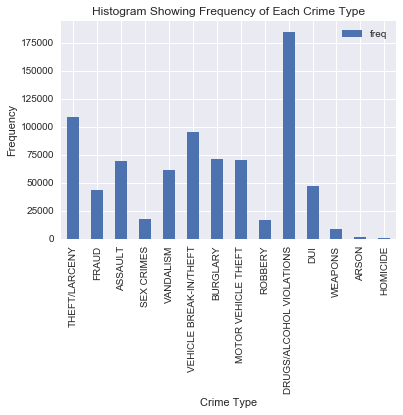

In [39]:
#Histogram showing crime type on the x-axis and frequency (over all cities) on the y-axis
#axes = df_crime['type'].drop_duplicates().plot(kind="hist", figsize = (8,6))
#axes.set(xlabel='crime type', ylabel='frequency', title='Histogram Displaying the Frequency of All Types of Crime')
#plt.show()
counts = df_crime['type'].value_counts()

def get_freq(row):
    return counts[row['type']]

df_plot = df_crime.loc[:, ['type']].drop_duplicates()
df_plot['freq'] = df_barplot.apply(get_freq, axis=1)
axes = df_plot[['type', 'freq']].plot.bar(figsize=(6,4))
axes.set_xticklabels(labels=df_plot.type, rotation=90)
axes.set(xlabel="Crime Type", ylabel="Frequency", title="Histogram Showing Frequency of Each Crime Type")
plt.show()